# Фермер, коровы, молоко.

### К нам обратился фермер. Он хочет купить коров и нужны ему только те коровы, которые дают `не менее 6000 кг` `вкусного молока` в год. 
**Заказчик предоставил данные своих коров и тех коров, которые он хочет купить.
Наша задача проанализировать датасеты, выбрать нужную модель для предсказания количества удоя и вкусноты молока у коров, которые фермер хочет купить. Результатом работы будет предоставление информации о коровах, удовлетворяющих обоим ключевым параметрам.**

## Загрузка данных

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (
    r2_score, 
    mean_absolute_error, 
    mean_squared_error, 
    accuracy_score, 
    precision_score, 
    recall_score, 
    confusion_matrix
)
import seaborn as sns
!pip install phik -q
import phik
import scipy.stats as st

**Добавим константы.**

In [2]:
RANDOM_STATE = 42

In [3]:
ferma_main = pd.read_csv('/datasets/ferma_main.csv', sep=';', decimal=',')
ferma_dad = pd.read_csv('/datasets/ferma_dad.csv', sep=';')
eco_ferma = pd.read_csv('/datasets/cow_buy.csv', sep=';', decimal=',')

ferma_main.info()
ferma_main.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 634 entries, 0 to 633
Data columns (total 12 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   id                                     634 non-null    int64  
 1   Удой, кг                               634 non-null    int64  
 2   ЭКЕ (Энергетическая кормовая единица)  634 non-null    float64
 3   Сырой протеин, г                       634 non-null    int64  
 4   СПО (Сахаро-протеиновое соотношение)   634 non-null    float64
 5   Порода                                 634 non-null    object 
 6   Тип пастбища                           634 non-null    object 
 7   порода папы_быка                       634 non-null    object 
 8   Жирность,%                             634 non-null    float64
 9   Белок,%                                634 non-null    float64
 10  Вкус молока                            634 non-null    object 
 11  Возрас

,id,"Удой, кг",ЭКЕ (Энергетическая кормовая единица),"Сырой протеин, г",СПО (Сахаро-протеиновое соотношение),Порода,Тип пастбища,порода папы_быка,"Жирность,%","Белок,%",Вкус молока,Возраст
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,Холмистое,Айдиал,3.40,3.075,не вкусно,более_2_лет
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,Равнинные,Соверин,3.73,3.073,вкусно,менее_2_лет


**Переименуем столбцы**

In [4]:
ferma_main = ferma_main.rename(columns={'Удой, кг':'milk_yield', 'ЭКЕ (Энергетическая кормовая единица)':'eke',\
'Сырой протеин, г':'crude_protein', 'СПО (Сахаро-протеиновое соотношение)':'spo', 'Порода':'breed', 'Тип пастбища':'pasture_type',\
'порода папы_быка':'dad_breed', 'Жирность,%':'fat_contain', 'Белок,%':'protein', 'Вкус молока':'milk_taste', 'Возраст':'age'})

In [5]:
ferma_main.head(3)

,id,milk_yield,eke,crude_protein,spo,breed,pasture_type,dad_breed,fat_contain,protein,milk_taste,age
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,Равнинное,Айдиал,3.58,3.076,вкусно,более_2_лет
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,Равнинные,Соверин,3.54,3.079,вкусно,менее_2_лет
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,Холмистое,Соверин,3.59,3.074,не вкусно,более_2_лет


In [6]:
ferma_dad.info()
ferma_dad.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 629 entries, 0 to 628
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        629 non-null    int64 
 1   Имя Папы  629 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.0+ KB


,id,Имя Папы
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин


In [7]:
ferma_dad = ferma_dad.rename(columns={'Имя Папы':'dad_name'})

In [8]:
eco_ferma.info()
eco_ferma.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Порода                   20 non-null     object 
 1   Тип пастбища             20 non-null     object 
 2   порода папы_быка         20 non-null     object 
 3   Имя_папы                 20 non-null     object 
 4   Текущая_жирность,%       20 non-null     float64
 5   Текущий_уровень_белок,%  20 non-null     float64
 6   Возраст                  20 non-null     object 
dtypes: float64(2), object(5)
memory usage: 1.2+ KB


,Порода,Тип пастбища,порода папы_быка,Имя_папы,"Текущая_жирность,%","Текущий_уровень_белок,%",Возраст
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


In [9]:
eco_ferma = eco_ferma.rename(columns={'Порода':'breed', 'Тип пастбища':'pasture_type','порода папы_быка':'dad_breed',\
'Имя_папы':'dad_name', 'Текущая_жирность,%':'fat_contain', 'Текущий_уровень_белок,%':'protein', 'Возраст':'age'})

In [10]:
eco_ferma.head(3)

,breed,pasture_type,dad_breed,dad_name,fat_contain,protein,age
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет


**Загрузили датафреймы, ознакомились с данными, переименовали наименования столбцов. Можно переходить к предобработке данных.**

##  Предобработка данных

In [11]:
print('Количество пропусков:', ferma_main.isna().sum())
print()
print('Количество явных дубликатов:', ferma_main.duplicated().sum())
print()
ferma_main[ferma_main.duplicated()]

Количество пропусков: id               0
milk_yield       0
eke              0
crude_protein    0
spo              0
breed            0
pasture_type     0
dad_breed        0
fat_contain      0
protein          0
milk_taste       0
age              0
dtype: int64

Количество явных дубликатов: 5



,id,milk_yield,eke,crude_protein,spo,breed,pasture_type,dad_breed,fat_contain,protein,milk_taste,age
629,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
630,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
631,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
632,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет
633,627,5970,14.4,1837,0.88,РефлешнСоверинг,Холмистое,Соверин,3.64,3.075,не вкусно,более_2_лет


In [12]:
ferma_main = ferma_main.drop_duplicates().reset_index(drop=True)

In [13]:
print('Количество пропусков:', ferma_dad.isna().sum())
print()
print('Количество явных дубликатов:', ferma_dad.duplicated().sum())
print()
ferma_dad[ferma_dad.duplicated()]

Количество пропусков: id          0
dad_name    0
dtype: int64

Количество явных дубликатов: 0



,id,dad_name


In [14]:
print('Количество пропусков:', eco_ferma.isna().sum())
print()
print('Количество явных дубликатов:', eco_ferma.duplicated().sum())
print()
eco_ferma[eco_ferma.duplicated()]

Количество пропусков: breed           0
pasture_type    0
dad_breed       0
dad_name        0
fat_contain     0
protein         0
age             0
dtype: int64

Количество явных дубликатов: 4



,breed,pasture_type,dad_breed,dad_name,fat_contain,protein,age
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет
8,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
14,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет
19,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет


**Не понятно, это дубликаты или нет. Параметров немного и здесь могут быть разные коровы с одинаковыми параметрами. Оставим их.**

In [15]:
ferma_main['pasture_type'].unique()

array(['Равнинное', 'Равнинные', 'Холмистое'], dtype=object)

In [16]:
ferma_main['dad_breed'].unique()

array(['Айдиал', 'Соверин', 'Айдиалл'], dtype=object)

In [17]:
duplicates = ['Равнинные', 'Равнинное']
name = 'равнинное'
ferma_main['pasture_type'] = ferma_main['pasture_type'].replace('Холмистое', 'холмистое')
ferma_main['pasture_type'] = ferma_main['pasture_type'].replace(duplicates, name)
ferma_main['dad_breed'] = ferma_main['dad_breed'].replace('Айдиалл', 'Айдиал')

In [18]:
ferma_main.describe()

,id,milk_yield,eke,crude_protein,spo,fat_contain,protein
count,629.00000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000
mean,315.00000,6188.750397,14.543879,1923.364070,0.913116,3.603657,3.075671
std,181.72094,1644.795489,1.306408,182.956251,0.032203,0.168656,0.002549
min,1.00000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.00000,5751.000000,13.500000,1771.000000,0.890000,3.590000,3.074000
50%,315.00000,6133.000000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.00000,6501.000000,15.600000,2062.000000,0.940000,3.720000,3.077000
max,629.00000,45616.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


**Видно аномалию в столбце `milk_yield` удой 45616 кг молока. Явно какая то ошибка. Удалим ее.**

In [19]:
ferma_main[ferma_main['milk_yield'] == 45616]

,id,milk_yield,eke,crude_protein,spo,breed,pasture_type,dad_breed,fat_contain,protein,milk_taste,age
16,17,45616,11.5,1675,0.93,Вис Бик Айдиал,холмистое,Айдиал,3.22,3.076,вкусно,более_2_лет


In [20]:
ferma_main.drop(ferma_main[ferma_main['milk_yield'] == 45616].index, inplace=True)
ferma_main.describe()

,id,milk_yield,eke,crude_protein,spo,fat_contain,protein
count,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000,628.000000
mean,315.474522,6125.968153,14.548726,1923.759554,0.913089,3.604268,3.075670
std,181.475367,475.857053,1.301777,182.832816,0.032221,0.168093,0.002551
min,1.000000,5204.000000,10.900000,1660.000000,0.840000,2.990000,3.069000
25%,158.750000,5749.750000,13.500000,1771.750000,0.890000,3.590000,3.074000
50%,315.500000,6132.500000,14.700000,1888.000000,0.930000,3.650000,3.076000
75%,472.250000,6501.000000,15.600000,2062.250000,0.940000,3.720000,3.077000
max,629.000000,7222.000000,16.800000,2349.000000,0.960000,3.750000,3.085000


**Удалим также и строку с ID 17 в таблице ferma_dad.csv**

In [21]:
ferma_dad.drop(ferma_dad[ferma_dad['id'] == 17].index, inplace=True)
ferma_dad.head(20)

,id,dad_name
0,1,Буйный
1,2,Соловчик
2,3,Барин
3,4,Буйный
4,5,Барин
5,6,Барин
6,7,Соловчик
7,8,Геркулес
8,9,Буйный
9,10,Барин


**Теперь все в порядке! Мы провели предобработку данных: убрали явные и неявные дубликаты, удалили аномалию.**

## Исследовательский анализ данных

**В данных 5 категориальных признаков, в каждом от 2 до 3 категорий.**

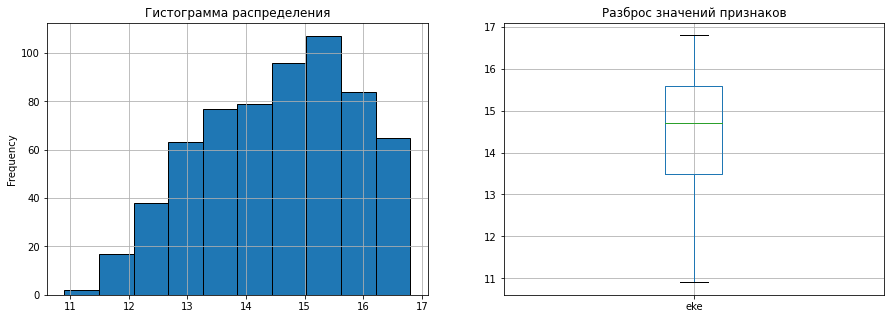

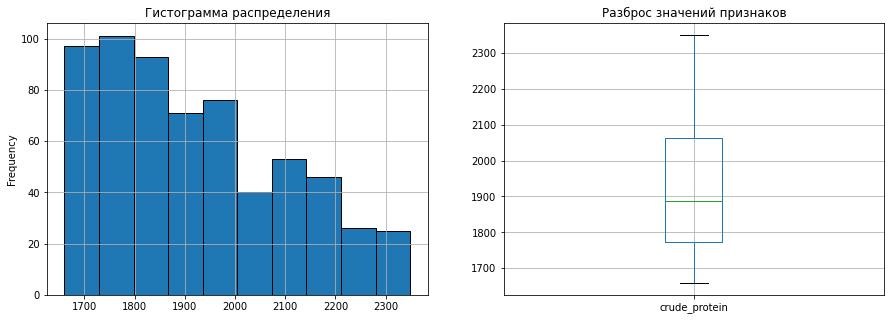

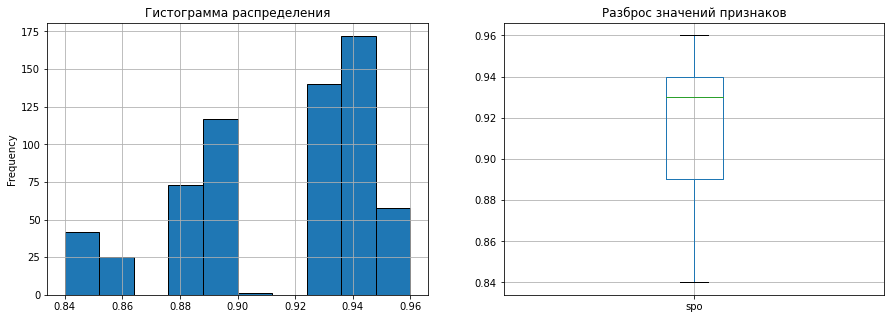

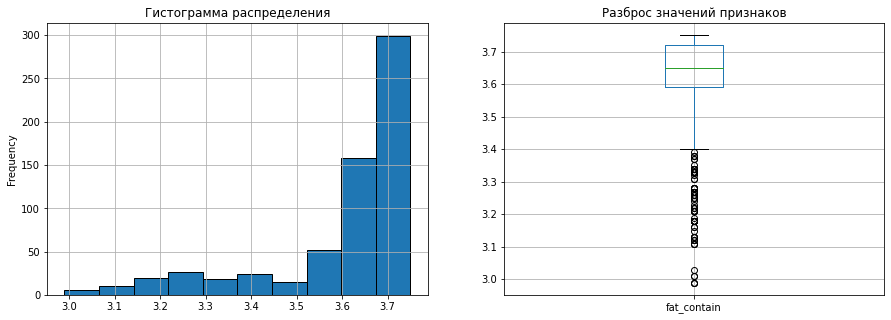

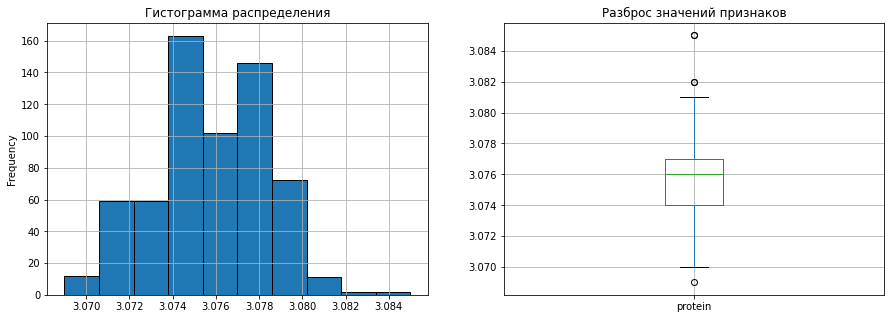

In [22]:
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'milk_taste', 'age']
num_col_names = ['eke', 'crude_protein', 'spo', 'fat_contain', 'protein']
ferma_main[cat_col_names].nunique()
for i in list(num_col_names):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
    ferma_main[i].plot(kind='hist', bins=10, grid=True, edgecolor='black', ax=axes[0])
    axes[0].set_title('Гистограмма распределения')
    ferma_main[i].plot(kind='box', grid=True, ax=axes[1])
    axes[1].set_title('Разброс значений признаков')
    plt.show()

**Построим такие же графики для целевого параметра.**

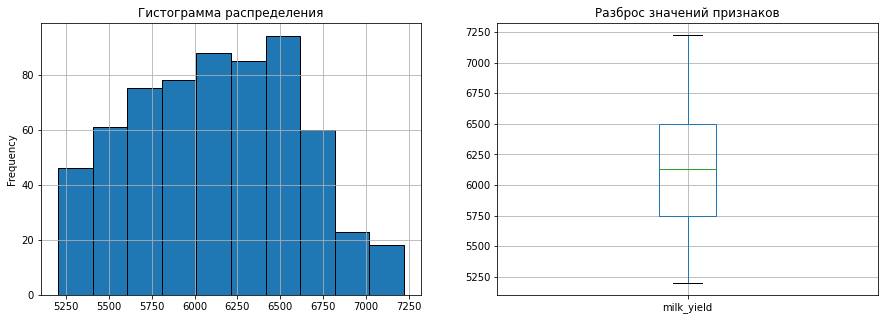

In [23]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ferma_main['milk_yield'].plot(kind='hist', bins=10, grid=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма распределения')
ferma_main['milk_yield'].plot(kind='box', grid=True, ax=axes[1])
axes[1].set_title('Разброс значений признаков')
plt.show()

- Несимметричное мультимодальное распределение показано на гистограмме распределения признака spo;
- Ассиметричное распределение с выбросами на гистограмме распределения признака fat_contain;
- Остальные диаграммы показывают ассиметричное нормальное распределение со смещением влево или вправо.

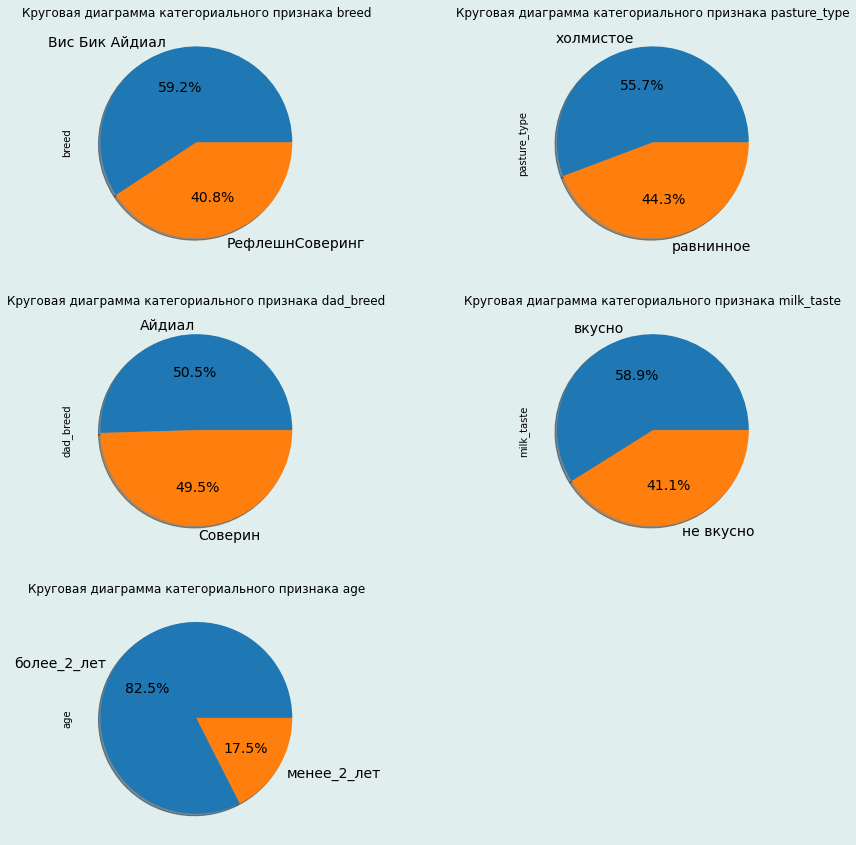

In [24]:
fig, axes = plt.subplots(nrows=3, ncols=2)
axe = axes.ravel()
for i, c in enumerate(cat_col_names):
    ferma_main[c].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title='Круговая диаграмма категориального признака ' +str(c), 
                                      figsize=(15,15),
                                      fontsize=14,
                                      ax=axe[i])
fig.delaxes(ax=axe[5])
fig.patch.set_facecolor('#E0EEEE')
plt.show()

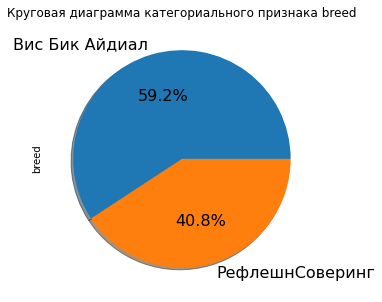

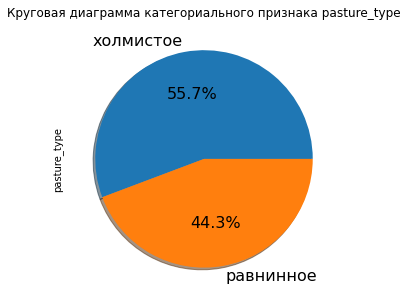

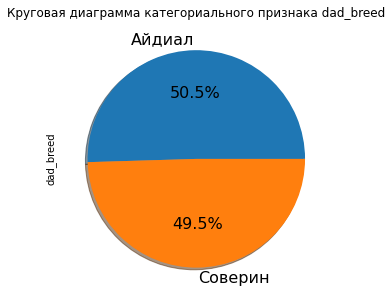

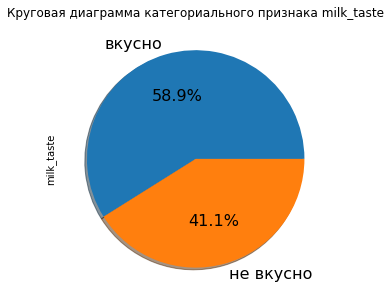

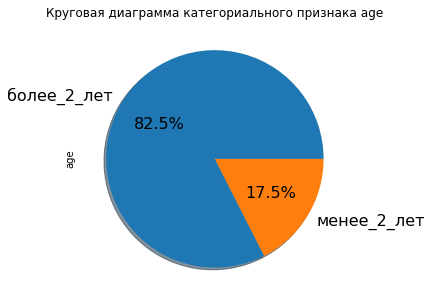

In [25]:
for i in list(cat_col_names):
    ferma_main[i].value_counts().plot(kind='pie', 
                                      shadow = True, 
                                      autopct = '%1.1f%%', 
                                      title='Круговая диаграмма категориального признака ' +str(i), 
                                      figsize=(5,5),
                                      fontsize=16 )
    plt.show()

**Категориальные признаки нужно закодировать.**

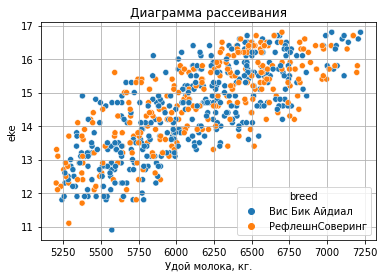

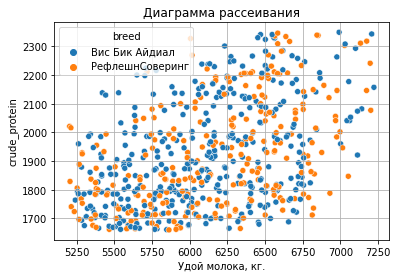

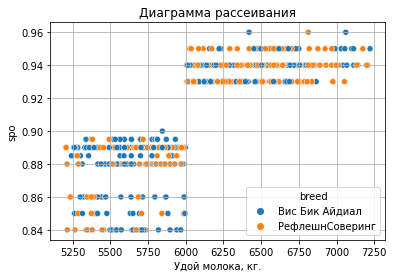

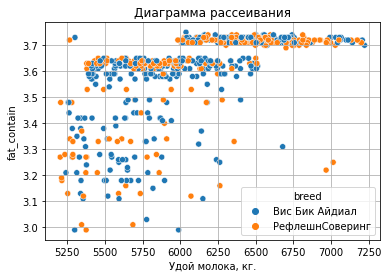

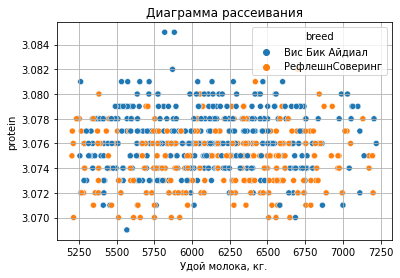

In [26]:
def plot_scatter(column):
    for i in list(column):
        sns.scatterplot(data=ferma_main, x="milk_yield", y=i, hue="breed")
        plt.xlabel('Удой молока, кг.')
        plt.ylabel(i)
        plt.grid()        
        plt.title('Диаграмма рассеивания')
        plt.show()
plot_scatter(num_col_names)

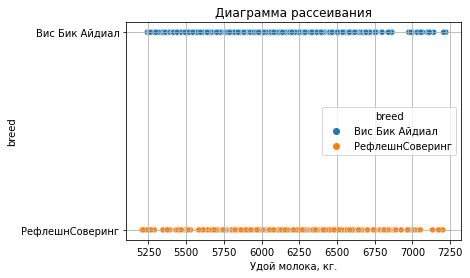

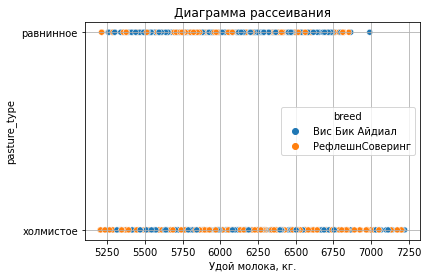

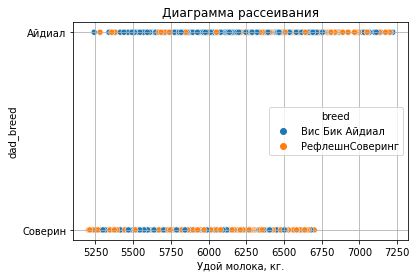

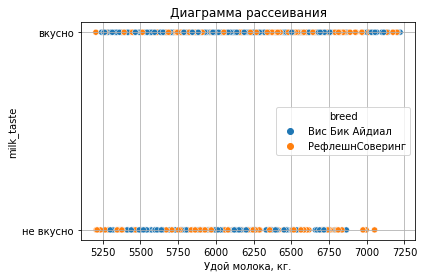

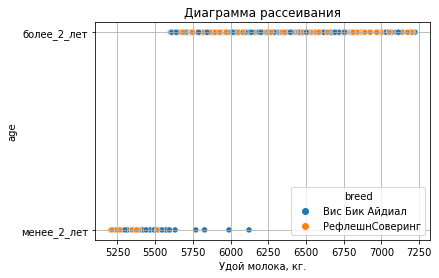

In [27]:
plot_scatter(cat_col_names)

- **По графику рассеивания видно, что признаки `SPO` и `Milk_yield` связаны нелинейно. Наблюдения сгруппированы в два кластера, причем SPO = 0,915 можно считать границей между кластерами.**
- **Коровы старше 2 лет почти всегда дают больше молока. Коровы, пасущиеся на холмистой местности так же дают больше молока. Еще порода быка-папы влияет на удой.**

## Корреляционный анализ

interval columns not set, guessing: ['id', 'milk_yield', 'eke', 'crude_protein', 'spo', 'fat_contain', 'protein']


<AxesSubplot:>

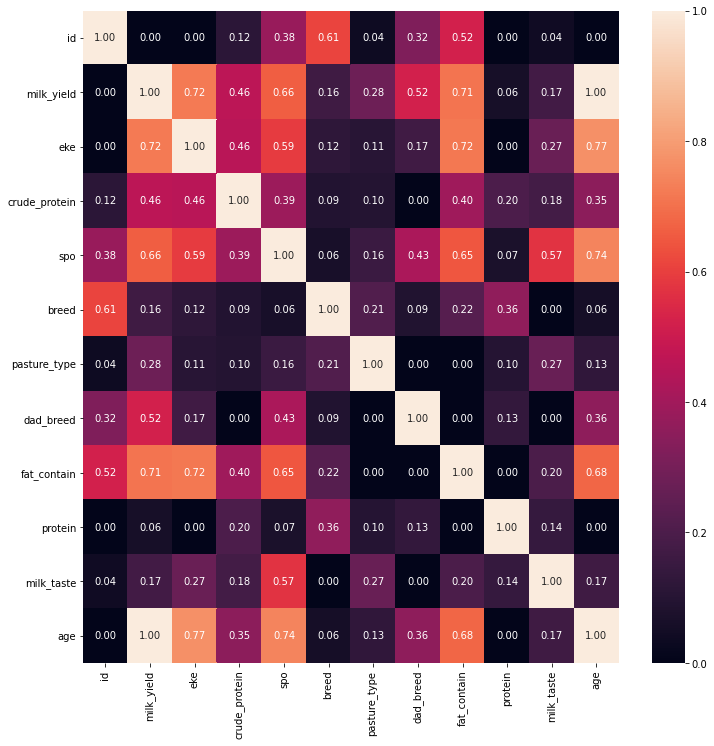

In [28]:
fig, ax = plt.subplots(figsize=(12, 12))
sns.heatmap(ferma_main.phik_matrix(), annot=True, fmt='.2f') 

**Целевой параметр - Удой молока показывает высокую тесноту связи с параметрами `eke` и `spo`, а также заметную связь с `fat_contain` и умеренную с `crude_protein` по шкале Шеддока. Так же стоит отметить довольно сильную связи между признаками `spo`, `eke`, `fat_contain` и `age`**

## Обучение модели линейной регрессии

In [29]:
X = ferma_main.drop('milk_yield', axis=1)
y = ferma_main['milk_yield']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age']
num_col_names = ['eke', 'spo', 'crude_protein']


In [30]:
encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

In [31]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train[:5]

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,eke,spo,crude_protein
0,1.0,1.0,1.0,0.0,1.502378,0.837130,1.079523
1,1.0,1.0,1.0,1.0,-1.557270,-0.703660,-0.196920
2,0.0,0.0,0.0,0.0,0.125537,-1.011818,-1.386085
3,0.0,1.0,0.0,0.0,-0.103937,0.837130,0.752230
4,0.0,0.0,0.0,0.0,-1.098323,-0.703660,0.828598


**Выполнили преобразование категориальных признаков, создали новый тренировочный и тестовый датасеты из отмасштабированных и закодированных данных.**

**Снова построим гистограмму распределения и ящик с усами для обработанных данных.**

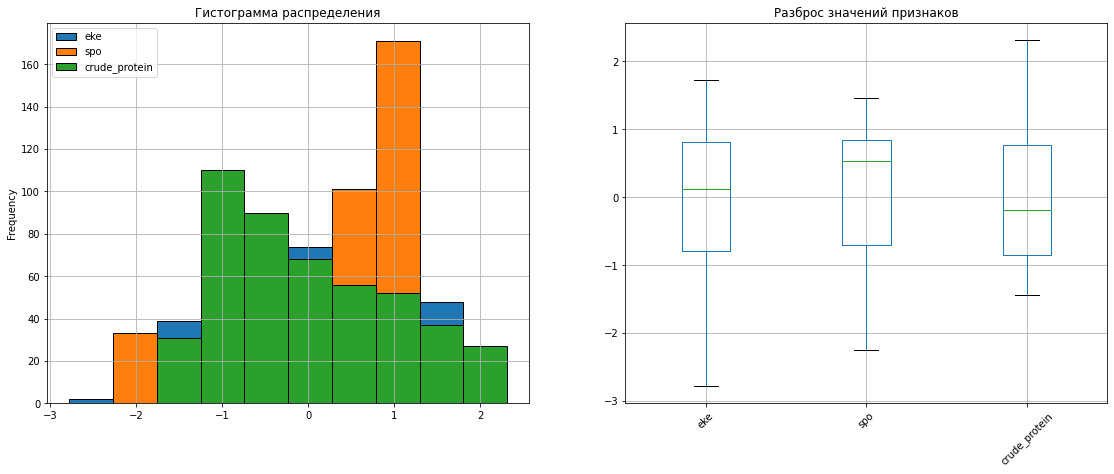

In [32]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19,7))

X_train[num_col_names].plot(kind='hist', bins=10, grid=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', grid=True, ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [33]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)
mse_first_model = mean_squared_error(y_test, predictions)
rmse_first_model = mean_squared_error(y_test, predictions, squared=False)
mae_first_model = mean_absolute_error(y_test, predictions)
r2_first_model = r2_score(y_test, predictions)
print(f' MSE = {mse_first_model:.3f}','\n', f'RMSE = {rmse_first_model:.3f}','\n', f'MAE = {mae_first_model:.3f}','\n', f'R2 = {r2_first_model:.3f}')

 MSE = 43887.015 
 RMSE = 209.492 
 MAE = 164.242 
 R2 = 0.784


**Судя по значению коэффициента детерминации, модель в 78,5% случаев предсказывает целевое значение ближе к истине, чем среднее.**

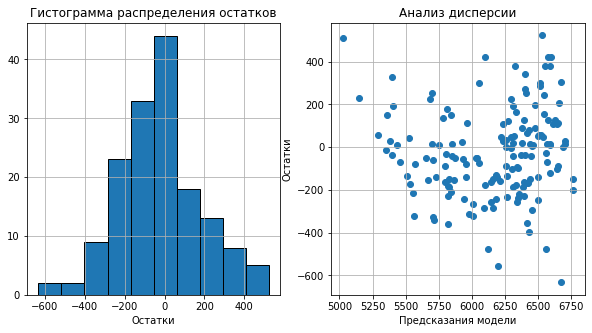

In [34]:
residuals = y_test - predictions

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].grid()

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
axes[1].grid()
plt.show()

**Модель делает предсказания с отклонениями от истинного значения от -600 до +500 кг. Довольно большой разброс, если учесть, что в среднем коровы дают 6125 кг молока в год, то отклонения составляют почти 10%. Нужно доработать модель.** 

**Категоризируем признак `spo`. Границу раздела кластеров мы определили как 0.915**

In [35]:
ferma_main['spo_cat'] = (
    ferma_main['spo']
    .where(ferma_main['spo'] >= 0.915, 0)
    .where(ferma_main['spo'] < 0.915, 1)    
)
ferma_main['eke_squared'] = ferma_main['eke']**2

In [36]:
ferma_main['spo_cat'].unique()

array([0., 1.])

**После обработки столбцов `spo` и `eke` построим новую модель.**

In [37]:
X = ferma_main.drop('milk_yield', axis=1)
y = ferma_main['milk_yield']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'spo_cat']
num_col_names = ['eke', 'crude_protein', 'eke_squared']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train[:5]

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_1.0,eke,crude_protein,eke_squared
0,1.0,1.0,1.0,0.0,1.0,1.502378,1.079523,1.577968
1,1.0,1.0,1.0,1.0,0.0,-1.557270,-0.196920,-1.511438
2,0.0,0.0,0.0,0.0,0.0,0.125537,-1.386085,0.082269
3,0.0,1.0,0.0,0.0,1.0,-0.103937,0.752230,-0.150235
4,0.0,0.0,0.0,0.0,0.0,-1.098323,0.828598,-1.102358


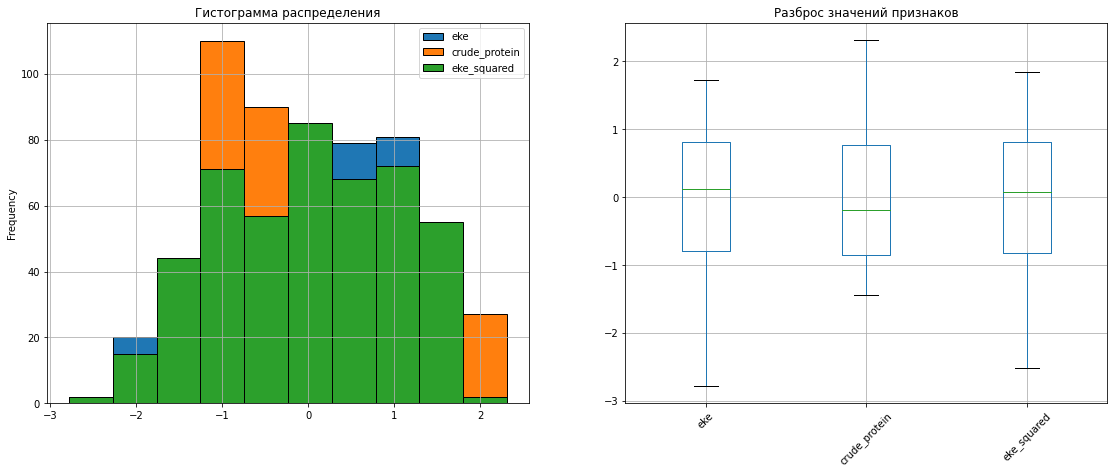

In [38]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19,7))

X_train[num_col_names].plot(kind='hist', bins=10, grid=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', grid=True, ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [39]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)
mse_second_model = mean_squared_error(y_test, predictions)
rmse_second_model = mean_squared_error(y_test, predictions, squared=False)
mae_second_model = mean_absolute_error(y_test, predictions)
r2_second_model = r2_score(y_test, predictions)
print(f' MSE = {mse_second_model:.3f}','\n', f'RMSE = {rmse_second_model:.3f}','\n', f'MAE = {mae_second_model:.3f}','\n', f'R2 = {r2_second_model:.3f}')

 MSE = 37187.221 
 RMSE = 192.840 
 MAE = 150.772 
 R2 = 0.817


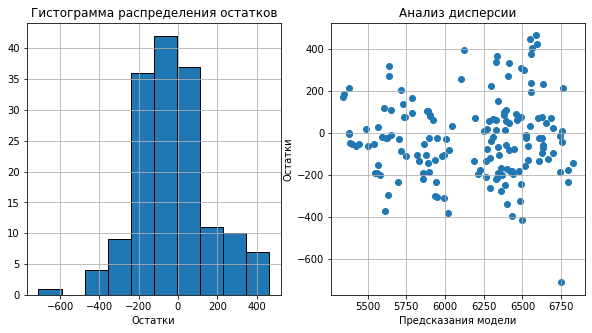

In [40]:
residuals = y_test - predictions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].grid()

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
axes[1].grid()
plt.show()

**Коэффициент детерминации увеличился до 81,8%. По графикам видно, что модель стала точнее предсказывать целевой параметр: точных предсказаний стало больше. В целом, остатки приблизились к 0. Вторая модель лучше справляется с предсказаниями, чем первая.**

**Добавим в данные новый признак и обучим на них третью модель LinearRegression.**

In [41]:
ferma_main = ferma_main.merge(ferma_dad, on= 'id')
ferma_main[ferma_main['id'] == 17]

,id,milk_yield,eke,crude_protein,spo,breed,pasture_type,dad_breed,fat_contain,protein,milk_taste,age,spo_cat,eke_squared,dad_name


In [42]:
X = ferma_main.drop('milk_yield', axis=1)
y = ferma_main['milk_yield']

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    random_state=RANDOM_STATE
)
cat_col_names = ['breed', 'pasture_type', 'dad_breed','age', 'dad_name', 'spo_cat']
num_col_names = ['eke', 'crude_protein', 'eke_squared']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

X_train[:5]

,x0_РефлешнСоверинг,x1_холмистое,x2_Соверин,x3_менее_2_лет,x4_Буйный,x4_Геркулес,x4_Соловчик,x5_1.0,eke,crude_protein,eke_squared
0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.502378,1.079523,1.577968
1,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,-1.557270,-0.196920,-1.511438
2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.125537,-1.386085,0.082269
3,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,-0.103937,0.752230,-0.150235
4,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,-1.098323,0.828598,-1.102358


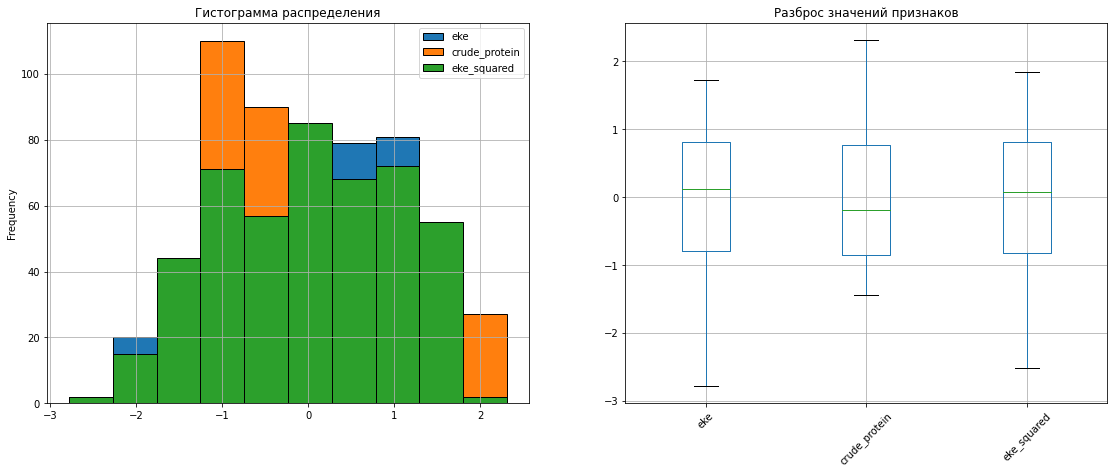

In [43]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(19,7))

X_train[num_col_names].plot(kind='hist', bins=10, grid=True, edgecolor='black', ax=axes[0])
axes[0].set_title('Гистограмма распределения')
X_train[num_col_names].plot(kind='box', grid=True, ax=axes[1], rot=45)
axes[1].set_title('Разброс значений признаков')
plt.show()

In [44]:
model_lr  = LinearRegression()
model_lr.fit(X_train, y_train)
predictions = model_lr.predict(X_test)
mse_third_model = mean_squared_error(y_test, predictions)
rmse_third_model = mean_squared_error(y_test, predictions, squared=False)
mae_third_model = mean_absolute_error(y_test, predictions)
r2_third_model = r2_score(y_test, predictions)
print(f' MSE = {mse_third_model:.3f}','\n', f'RMSE = {rmse_third_model:.3f}','\n', f'MAE = {mae_third_model:.3f}','\n', f'R2 = {r2_third_model:.3f}')

 MSE = 34844.101 
 RMSE = 186.666 
 MAE = 145.506 
 R2 = 0.829


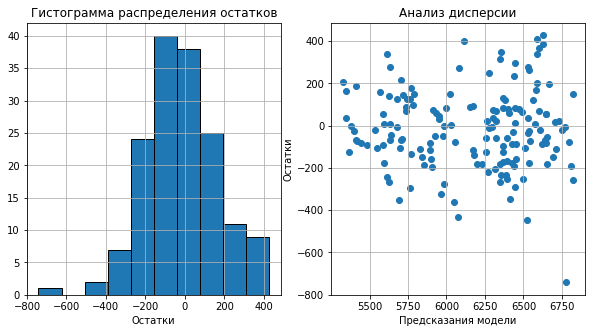

In [45]:
residuals = y_test - predictions
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,5))
axes[0].hist(residuals, edgecolor='black')
axes[0].set_title('Гистограмма распределения остатков')
axes[0].set_xlabel('Остатки')
axes[0].grid()

axes[1].scatter(predictions, residuals)
axes[1].set_xlabel('Предсказания модели')
axes[1].set_ylabel('Остатки')
axes[1].set_title('Анализ дисперсии')
axes[1].grid()
plt.show()

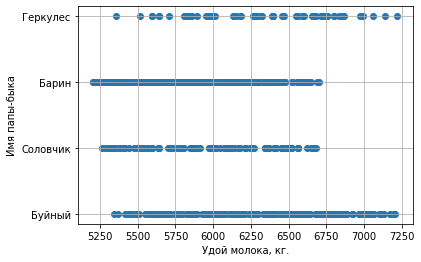

In [46]:
plt.scatter(ferma_main['milk_yield'], ferma_main['dad_name'])
plt.xlabel('Удой молока, кг.')
plt.ylabel('Имя папы-быка')
plt.grid()
plt.show()

**Добавление еще одного признака немного улучшило модель. R2 вырос до 83%, и остатки еще немного приблизились к 0. Получается, третья модель пока самая точная.**

**Оценим качество каждой модели по трём метрикам: MSE, MAE, RMSE.**

In [47]:
print('Метрики первой модели', '\n', f'MSE = {mse_first_model:.3f}','\n', f'RMSE = {rmse_first_model:.3f}','\n', f'MAE = {mae_first_model:.3f}')
print('Метрики второй модели', '\n', f'MSE = {mse_second_model:.3f}','\n', f'RMSE = {rmse_second_model:.3f}','\n', f'MAE = {mae_second_model:.3f}')
print('Метрики третьей модели', '\n', f'MSE = {mse_third_model:.3f}','\n', f'RMSE = {rmse_third_model:.3f}','\n', f'MAE = {mae_third_model:.3f}')

Метрики первой модели 
 MSE = 43887.015 
 RMSE = 209.492 
 MAE = 164.242
Метрики второй модели 
 MSE = 37187.221 
 RMSE = 192.840 
 MAE = 150.772
Метрики третьей модели 
 MSE = 34844.101 
 RMSE = 186.666 
 MAE = 145.506


**Рассчитаем доверительный интервал прогноза по удою.**

In [48]:
st.norm.interval(confidence=0.95, loc=np.mean(predictions), scale=st.sem(predictions))

(6092.9082460909995, 6222.7948790998835)

**Доверительный интервал показывает, что в 95% случаев, предсказанный целевой признак будет находиться в доверительном интервале. Для фермера это означает диапазон годового удоя у 95% коров.**

**С помощью лучшей модели спрогнозируем удой коров, которых фермер хочет купить.**

In [49]:
eco_ferma['eke'] = ferma_main['eke'].mean() * 1.05
eco_ferma['spo'] = ferma_main['spo'].mean() * 1.05
eco_ferma['crude_protein'] = ferma_main['crude_protein'].mean() * 1.05
eco_ferma['spo_cat'] = (
    eco_ferma['spo']
    .where(eco_ferma['spo'] >= 0.915, 0)
    .where(eco_ferma['spo'] < 0.915, 1)    
)
eco_ferma['eke_squared'] = eco_ferma['eke']**2
eco_ferma.head()

,breed,pasture_type,dad_breed,dad_name,fat_contain,protein,age,eke,spo,crude_protein,spo_cat,eke_squared
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138


In [50]:
X = ferma_main.drop('milk_yield', axis=1)
y = ferma_main['milk_yield']

cat_col_names = ['breed', 'pasture_type', 'dad_breed','age', 'dad_name', 'spo_cat']
num_col_names = ['eke', 'crude_protein', 'eke_squared']

X_test_ohe = encoder.transform(eco_ferma[cat_col_names])

X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_test_scaled = scaler.transform(eco_ferma[num_col_names])

X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

predictions = model_lr.predict(X_test)
eco_ferma['milk_yield'] = predictions

In [51]:
eco_ferma.head()

,breed,pasture_type,dad_breed,dad_name,fat_contain,protein,age,eke,spo,crude_protein,spo_cat,eke_squared,milk_yield
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6581.069175
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6308.701838
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6263.024906
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6571.763131
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6525.082196


**Создали 3 модели, пошагово улучшая предыдущие. Последняя, третья модель получилась наиболее точной. Была бы побольше выборка и побольше признаков, можно было бы улучшить модель. На данном этапе  разультат предсказания нашей модели ближе к истинному значению в 83% случаев, чем среднее значение целевого признака. При помощи лучшей модели предсказали годовой удой коров, которые хочет купить заказчик.**

## Обучение модели логистической регрессии

In [52]:
ferma_main['milk_taste'] = ferma_main['milk_taste'].replace('вкусно', 1)
ferma_main['milk_taste'] = ferma_main['milk_taste'].replace('не вкусно', 0)

In [53]:
ferma_main['fat_contain_cat'] = (
    ferma_main['fat_contain']
    .where(ferma_main['fat_contain'] <= 3.68, 'высокая')
    .where(ferma_main['fat_contain'] > 3.45, 'низкая')
    .where((ferma_main['fat_contain'] == 'высокая') | (ferma_main['fat_contain'] == 'низкая'), 'средняя')
)
eco_ferma['fat_contain_cat'] = (
    eco_ferma['fat_contain']
    .where(eco_ferma['fat_contain'] <= 3.68, 'высокая')
    .where(eco_ferma['fat_contain'] > 3.45, 'низкая')
    .where((eco_ferma['fat_contain'] == 'высокая') | (eco_ferma['fat_contain'] == 'низкая'), 'средняя')
)

In [54]:
ferma_main.head()

,id,milk_yield,eke,crude_protein,spo,breed,pasture_type,dad_breed,fat_contain,protein,milk_taste,age,spo_cat,eke_squared,dad_name,fat_contain_cat
0,1,5863,14.2,1743,0.890,Вис Бик Айдиал,равнинное,Айдиал,3.58,3.076,1,более_2_лет,0.0,201.64,Буйный,средняя
1,2,5529,12.8,2138,0.890,Вис Бик Айдиал,равнинное,Соверин,3.54,3.079,1,менее_2_лет,0.0,163.84,Соловчик,средняя
2,3,5810,14.0,1854,0.885,РефлешнСоверинг,холмистое,Соверин,3.59,3.074,0,более_2_лет,0.0,196.00,Барин,средняя
3,4,5895,12.4,2012,0.885,РефлешнСоверинг,холмистое,Айдиал,3.40,3.075,0,более_2_лет,0.0,153.76,Буйный,средняя
4,5,5302,12.8,1675,0.885,Вис Бик Айдиал,равнинное,Соверин,3.73,3.073,1,менее_2_лет,0.0,163.84,Барин,средняя


In [55]:
X = ferma_main.drop(columns=['milk_taste'])
y = ferma_main['milk_taste']

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    random_state=RANDOM_STATE
)
cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'dad_name', 'spo_cat', 'fat_contain_cat']
num_col_names = ['eke', 'protein', 'crude_protein', 'eke_squared']

encoder = OneHotEncoder(drop='first', sparse=False)
X_train_ohe = encoder.fit_transform(X_train[cat_col_names])
X_test_ohe = encoder.transform(X_test[cat_col_names])
encoder_col_names = encoder.get_feature_names()

X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_col_names])
X_test_scaled = scaler.transform(X_test[num_col_names])

X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_col_names)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

clf = LogisticRegression(random_state=RANDOM_STATE)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
print('Метрики логистической регрессии:', '\n', f'Accuracy = {accuracy:.3f}','\n', f'Recall = {recall:.3f}','\n', f'Precision = {precision:.3f}')

Метрики логистической регрессии: 
 Accuracy = 0.624 
 Recall = 0.852 
 Precision = 0.620


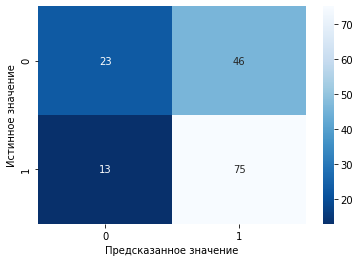

In [56]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('Истинное значение')
plt.xlabel('Предсказанное значение'); 

**Фермеру важен вкус молока, значит нам не так страшно случайно отсеять вкусное молоко, чем принять невкусное. Поэтому нам важна в этой задаче метрика `precision`.**

**Сведем критичную ошибку к нулю: для этого измените порог принадлежности к классам.**

In [57]:
prob_one_valid = clf.predict_proba(X_test)[:,1]    

for i in np.arange(0.5, 0.85, 0.01):
    y_pred = prob_one_valid > i
    print('порог: ', i, 'precision: ', precision_score(y_test, y_pred), 'accuracy: ', accuracy_score(y_test, y_pred))
    

порог:  0.5 precision:  0.6198347107438017 accuracy:  0.6242038216560509
порог:  0.51 precision:  0.625 accuracy:  0.6305732484076433
порог:  0.52 precision:  0.625 accuracy:  0.6305732484076433
порог:  0.53 precision:  0.646551724137931 accuracy:  0.6560509554140127
порог:  0.54 precision:  0.646551724137931 accuracy:  0.6560509554140127
порог:  0.55 precision:  0.6607142857142857 accuracy:  0.6687898089171974
порог:  0.56 precision:  0.6576576576576577 accuracy:  0.6624203821656051
порог:  0.5700000000000001 precision:  0.6728971962616822 accuracy:  0.6751592356687898
порог:  0.5800000000000001 precision:  0.6826923076923077 accuracy:  0.6815286624203821
порог:  0.5900000000000001 precision:  0.696969696969697 accuracy:  0.6878980891719745
порог:  0.6000000000000001 precision:  0.7157894736842105 accuracy:  0.7006369426751592
порог:  0.6100000000000001 precision:  0.75 accuracy:  0.7197452229299363
порог:  0.6200000000000001 precision:  0.7710843373493976 accuracy:  0.726114649681528

**Разбили датасет на учебную и тренировочную выборки, сделали необходимые преобразования, обучили модель. Подобрали порог, при котором у фермера самые высокие шансы получить корову, удовлетворяющую заявленным условиям. Теперь осталось применить модель к датасету с коровами.**

In [58]:
X = ferma_main.drop(columns=['milk_taste'])
y = ferma_main['milk_taste']

cat_col_names = ['breed', 'pasture_type', 'dad_breed', 'age', 'dad_name', 'spo_cat', 'fat_contain_cat']
num_col_names = ['eke', 'protein', 'crude_protein', 'eke_squared']


X_test_ohe = encoder.transform(eco_ferma[cat_col_names])

X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

X_test_scaled = scaler.transform(eco_ferma[num_col_names])

X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_col_names)

X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)
THRESHOLD = 0.81
y_pred = np.where(clf.predict_proba(X_test)[:,1] > THRESHOLD, 1, 0)

eco_ferma['milk_taste'] = y_pred
eco_ferma.head()

,breed,pasture_type,dad_breed,dad_name,fat_contain,protein,age,eke,spo,crude_protein,spo_cat,eke_squared,milk_yield,fat_contain_cat,milk_taste
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6581.069175,средняя,0
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6308.701838,средняя,0
2,РефлешнСоверинг,равнинное,Соверин,Барин,3.59,3.074,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6263.024906,средняя,0
3,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.061,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6571.763131,средняя,0
4,РефлешнСоверинг,равнинное,Айдиал,Буйный,3.64,3.074,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6525.082196,средняя,0


In [59]:
bue = eco_ferma.query('milk_yield >= 6000 & milk_taste == 1').reset_index(drop=True)
bue

,breed,pasture_type,dad_breed,dad_name,fat_contain,protein,age,eke,spo,crude_protein,spo_cat,eke_squared,milk_yield,fat_contain_cat,milk_taste


In [60]:
eco_ferma['milk_taste'] = np.array(clf.predict_proba(X_test)[:,1])
eco_ferma.query('(milk_yield > 6000)').sort_values(by='milk_taste', ascending=False).head()

,breed,pasture_type,dad_breed,dad_name,fat_contain,protein,age,eke,spo,crude_protein,spo_cat,eke_squared,milk_yield,fat_contain_cat,milk_taste
9,РефлешнСоверинг,холмистое,Айдиал,Буйный,3.40,3.079,менее_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6339.030828,средняя,0.735954
0,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6581.069175,средняя,0.705253
6,Вис Бик Айдиал,холмистое,Айдиал,Геркулес,3.58,3.076,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6581.069175,средняя,0.705253
16,Вис Бик Айдиал,холмистое,Соверин,Соловчик,3.73,3.079,более_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6324.465127,средняя,0.693396
1,Вис Бик Айдиал,равнинное,Соверин,Буйный,3.54,3.081,менее_2_лет,15.276162,0.958744,2019.947532,1.0,233.361138,6308.701838,средняя,0.655246


## Итоговые выводы

**Из всей выборки коров, выбранных фермером, с минимальным риском для себя он не сможет приобрести ни одной коровы. Поскольку для фермера был важен вкус молока, пришлось настраивать модель, исключающую возможность покупки коровы, дающей не вкусное молоко. В итоге не осталось коров, удовлетворяющих критериям клиента. Однако, мы подобрали 3 коровы, максимально подходящих под условия покупки (это коровы с id 0, 6 и 9), и если удастся договориться по стоимости, то фермер получит неплохих коров с годовым удоем выше медианного значения его стада и с вероятностью более 70%, что молоко будет вкусным. Тем самым компенсировав возможные риски.**
 - **Для улучшения результатов модели можно было бы попросить добавить новые параметры: сезон года и сезон отела, живая масса, состояние здоровья.**
 - **Чтобы улучшить модель линейной регрессии мы избавились от нелинейной зависимости входных признаков и добавили новый признак.**
 - **Модель логистической регрессии мы подгоняли под нужды фермера настройкой порога.**
 - **При анализе рисков важны метрики `recall` и `precision` они позволяют более точно настроить модель под нужды бизнеса.**